In [1]:
import igraph as ig
import sys, time, re
from random import randint
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pylab as plt
import numpy as np
from importlib import reload
import sys
import pickle
sys.path.append('../scripts')
%matplotlib inline 
folder = '../data/'

import ml_utils as utils
reload(utils)

<module 'ml_utils' from '../scripts/ml_utils.py'>

### Read graphs

In [2]:
import cyrtranslit

def read_edges(f_name):
    print(f_name)
    g = ig.Graph.Read_Ncol(f_name, names=True, directed=False)
    ig.summary(g)
    return g

def enrich_vk_graph(g):
    data_dict = dict()
    pat = re.compile("(\d+),(.*),(.*),(.*)")
    pat_word = re.compile('[^a-zA-Zа-яА-Я\d\s]+')
    
    g.vs['fname'] = ''
    g.vs['uid'] = None
    
    with open(folder + 'vk_personal2.csv', 'r') as f:
        for line in f:
            try:
                uid, uname, name1, name2 = pat.match(line).groups()
                name1 = re.sub(pat_word, '', name1).strip().lower()
                name2 = re.sub(pat_word, '', name2).strip().lower()
                data_dict[uid] = (uname, name1 + ' ' + name2)
            except AttributeError:
                print(line)
    for v in g.vs:
        uid = v['name']
        uname, fname = data_dict[uid]
        v['name'] = uname
        v['uid'] = int(uid)
        v['fname'] = cyrtranslit.to_latin(fname, 'ru').replace("'", '')

def enrich_insta_graph(g):
    data_dict = dict()
    pat = re.compile("(\d+),(.*),(.*)")
    pat_word = re.compile('[^a-zA-Zа-яА-Я\d\s]+')
    
    g.vs['fname'] = ''
    g.vs['uid'] = None
    
    with open(folder + 'inst_personal.csv', 'r') as f:
        for line in f:
            uid, uname, fname = pat.match(line).groups()
            fname = re.sub(pat_word, '', fname).strip().lower()
            data_dict[uid] = (uname, fname)

    for v in g.vs:
        uid = v['name']
        uname, fname = data_dict[uid]
        v['name'] = uname
        v['uid'] = int(uid)
        v['fname'] = cyrtranslit.to_latin(fname, 'ru').replace("'", '')

In [3]:
inst_g = read_edges(folder + 'inst_lid_rid.csv')
enrich_insta_graph(inst_g)

vk_g = read_edges(folder + 'vk_lid_rid.csv')
enrich_vk_graph(vk_g)

../data/inst_lid_rid.csv
IGRAPH UN-- 20794 240414 -- 
+ attr: name (v)
../data/vk_lid_rid.csv
IGRAPH UN-- 24800 463468 -- 
+ attr: name (v)


In [4]:
vk_g.write_pickle(fname=os.path.join(folder, 'vk.pickle'))
inst_g.write_pickle(fname=os.path.join(folder, 'inst.pickle'))

In [5]:
vk_g = ig.Graph.Read_Pickle(os.path.join(folder, 'vk.pickle'))
inst_g = ig.Graph.Read_Pickle(os.path.join(folder, 'inst.pickle'))

### test

In [6]:
vk_g.vs[0].degree()

16

In [7]:
matches_file_name = 'matches_s_01_th_091_t_10-12_13:19.pickle'
lid_rid = utils.read_matches(matches_file_name, threshold = 91, is_repeat=True)

me/ildar/projects/pycharm/social_network_revealing/graphmatching/matches/repeat/091/matches_s_01_th_091_t_10-12_13:19.pickle
matches len 4765
(78897392, 608311198)
(20158885, 482179932)
(12852529, 294223340)
(239645190, 53256746)
(134652490, 4145166609)


In [8]:
res = []
for lid, rid in lid_rid:
    ind_l = vk_g.vs.find(uid=lid).index
    ind_r = inst_g.vs.find(uid=rid).index
    res.append((ind_l, ind_r))
print('Len lid_rid and res is same', len(lid_rid) == len(res))

78897392 608311198
20158885 482179932
12852529 294223340
239645190 53256746
134652490 4145166609
19465441 4596401648
63936438 1229223403
10840997 237717825
514182 2960136809
6748985 3683629281
5867636 518622210
107229627 1914267519
3304988 277475313
789964 450944618
14676261 1405412266
94745843 1097657099
306027913 4052921963
23377952 365638971
30310518 350710244
2560688 2908982445
85994394 298886284
72182760 428313840
79844340 1354328971
7802895 2043045920
241457839 1424902790
6610255 25812746
28635097 550011901
18723020 1359151615
4467540 195258119
76013736 348304880
12291237 267539368
3111946 33834803
20433857 288937167
209991504 903722467
54351865 248545577
150429458 544437984
2215300 680261927
148903306 322466176
3270317 224408146
272379 3501250
79349624 3936022284
32878339 1570469279
55046455 4053552236
23253281 394144182
62576481 193201572
4307020 13585567
16902093 491966188
4323366 4430359
365511709 3245140099
4017116 350269540
1912672 1565421034
628199 191660379
3800072 294825

285181168 1635215574
2043755 9030461
52132291 1474160085
691065 44083231
3124925 637419065
151020141 208940916
94436211 1461876519
42443844 529826744
148097710 437447222
8523117 408800302
17163906 1216575130
7579741 499988738
154766 29965849
290926229 1516873109
28095956 402128089
10032915 3028937520
46095676 1693406525
12720831 254012584
91739311 1475863041
9071626 177393104
91125628 1427446690
143082702 1285372141
9490149 38608326
3783433 236630926
30116235 382905447
344671889 38691775
17256780 263218865
152809029 2978180348
179646662 1352123974
80304546 567634781
1822341 365654581
4880059 1386172040
16068575 1558638501
2951773 1383803060
1693779 395286450
13873322 1354148388
71592425 2954296701
31247980 1393192831
9886688 1991750760
2598762 1431917634
158443582 4091015645
19720118 1568942211
42232744 1098875907
16086239 2037771694
172913161 286685811
26486807 716757626
127301112 1503786994
5490279 506005129
22620449 891624123
100938856 3678534408
21791884 860117227
26507089 17823775

3790179 5167756
248209036 175363779
8863313 258306844
5774998 398867234
14678012 27578105
145604608 2222626347
100869028 369640238
23725658 2066768698
3056245 182161698
63939122 2278967806
5082198 336724527
31111395 1333023995
3604213 578931482
8019724 270045481
11693829 30959732
27271910 339063041
72717 43736239
16438552 46794881
20678406 407924877
25800518 1435750280
215734 1542096743
10413631 698631281
55134820 1119940913
126855672 511893282
35480189 1297019200
19594955 1234204452
86741758 461748239
21827222 531556854
137806102 479270838
10723577 293730481
115804916 1231713287
985527 4491364
3789177 2173960694
1292485 236519517
3290543 34175492
55755612 506752223
52170683 577522289
12838829 1148602446
29029005 545945590
17967376 1124469348
41455807 324682668
45547 41380181
23050108 1543944488
327350720 2532618136
147120286 1594415229
70526394 269981537
157627553 3678390214
106495104 1143177678
1177408 479957567
364939663 2996095920
171228180 242856512
104970191 1224933182
53583590 1

136868577 201453776
5494460 1378939046
2399914 420151741
1312646 1099010937
75176295 1090239068
49595538 284269177
4180444 281935790
5148978 35532529
92664 33145582
478062 245591159
3663831 309809902
11753184 1148256584
91967810 783583913
9435928 182741954
80548697 4544477848
19804273 198018077
120186386 285484574
277675663 293291551
584404 1649590596
10363636 580766112
412133 11829991
5829443 280654144
9348351 224705680
64646285 3451681663
36146130 306329311
137124856 1826541180
154355566 1491649841
15103994 357229002
204689671 1787028382
17744278 1528231896
9634193 448637809
149274724 554696542
140718152 3314454381
1499094 1543303043
25013835 501568371
49837501 1960167808
5537862 177196031
105497928 255198424
8538244 577970879
54059049 1288694579
31310380 4852366389
6029047 1977172089
133016495 1497504388
251766989 1256313133
12344089 2980829562
570519 275318184
47656147 1547725228
152013649 215819011
1265842 318055821
6676758 469304172
161362722 348972442
11712185 469329323
41473578

1450464 310507291
4460777 199165594
8487848 687715632
113017459 4254830004
17234490 191325146
3103436 566083251
16484700 240513422
134553 513618874
41557636 240768122
39181699 1585089293
10440804 394998915
94574927 33871134
28373856 558813572
29271324 1416988178
95386937 1236052487
107352044 1955672021
199167579 1228262687
162218323 2012492708
6090787 1317901990
7935059 190499212
17564143 1216835570
21687372 1607867824
8301339 327464461
63833277 417802733
107219492 3575818885
19363966 375960885
90662722 283790486
6394900 201059770
39881470 1529947862
9352497 367671705
144236060 1367799118
7054689 297974759
69817315 1302694804
3571648 33925607
179460159 1102984578
45080847 772681244
116819960 1062009233
138627494 276416389
621826 981516258
333075587 2415209168
4067700 285871753
692142 199124716
282517545 350397155
708702 259345119
5199084 293341949
66581298 3028549073
2510176 203739123
55586247 920128053
40509075 281225401
5881372 1173681831
3247770 341250644
27156630 306673184
21961473

25671965 1419237284
151787757 422386404
1561528 2251082891
8945509 368381563
16361422 227515354
22483117 994399853
85514920 201141271
31531314 384080212
3104645 1692208058
135773422 207505912
7732674 219163293
3025943 288592412
194675856 1496244335
651542 925449583
36413438 1495376915
366125343 1227676918
8235188 1280794862
4180667 550551061
74068109 531640013
10335393 901835053
100294432 404850064
3638557 1604182524
2410032 1041584289
148647430 1336493262
11888949 1491889782
169387824 1700844713
16252207 230385302
5579129 477211657
234422 35465899
151919900 579101312
9435325 334698434
1695332 1558974385
2884809 352393053
15395625 225994986
58704544 1035784826
35489508 2286910082
85286466 648379856
152996528 1456281522
67412149 1104561587
56500971 1361002886
158024932 466786241
3058035 210832012
9806967 282216887
137395638 480719419
5129895 1430631759
42055912 358748434
905226 334175636
7514913 217965041
212025699 402073004
19835897 198818151
2524601 1264713112
6566446 180094878
445466

216384864 1958354815
197823264 1429618513
7590963 33360367
143555943 1645895328
162936778 2089526672
351155486 2909142824
15157351 550684536
154899266 2130228896
1544797 446089206
3461911 444376954
111930890 1682464873
2931702 182521505
262161540 1533270812
13646682 266471371
6545538 315335720
2896228 400363174
78863822 2467726247
46263005 290869110
13822128 285471814
4750030 352554779
179511140 813476677
94186870 1550155076
225720484 513332425
30706563 383950181
2750282 4210927105
209934752 44420076
265846 2141564301
198903130 306563482
9494048 296753618
17413218 2184434556
1135229 424043613
19037678 1557258368
667241 263153501
8399102 1536305231
144828817 3165303455
206821049 1089765058
5454859 146039966
321975636 2225959730
5636875 645574241
49890173 779964412
13290445 4001552558
39101503 296020247
140471035 419630160
76624409 1422875668
1123688 631272409
58349865 1048803535
180028362 1900465808
49800179 1515000940
126675003 495933822
63408681 258309436
20711164 233819042
81771520 3

103959555 53761924
4202279 46761514
102769151 349732151
291672590 263389230
9106615 233885644
200022863 2065173370
25569317 1563970805
229011352 1617505648
957225 1391200406
50301171 1503352341
13162910 639359755
8196527 261913923
132064576 1516992125
132615872 2057748976
56284672 1123822182
21522329 567197905
293276212 318067060
1621052 11024980
33258866 296469671
764647 315963229
25022624 296796355
85711871 1460380585
38305482 589470816
23966568 732014163
45488039 570849090
66763111 2541206627
139953278 1594358723
39606725 1805275548
3360830 215458533
84923226 497358730
96048691 562183340
2338209 888782899
76564521 1362907768
328808578 1044594476
4473795 199522970
307380776 1522242492
375690564 2257895163
10170570 32994357
16807645 445335796
32737383 50405509
142157868 2282010006
21271044 1185033820
11640201 214123598
132924118 290220633
8776032 2132139102
4565389 265257017
8537508 967786871
134201903 259493470
5498843 532960231
63648 678681155
72584544 645858951
28801362 328871359
1

14114543 395691127
166744090 529191829
4205649 910073974
9373938 146097744
5674940 4579458590
57611765 231735707
33435700 334435366
391226495 992868823
25378938 1415610578
134901939 1106346636
85112303 1446214531
28085038 1496567523
16148679 264227638
29074240 283571637
1047557 287870298
17804921 1193761737
99645034 2248112847
136244024 630717250
7175120 185485152
27274830 300581369
3257181 1449869008
70457024 467044269
7533165 2207682521
402627366 4296310382
7210735 351988863
234509256 1590071683
353302686 3184751105
5947712 2311776800
45846754 1500759913
78604430 293144264
21370955 1425077756
7664100 1522807702
65288571 282158605
6540140 241397004
152045030 41332047
31809362 4038382402
63486115 1693942282
91307614 359801190
133286834 599683596
4167731 255737895
33125457 349928597
14499229 2949984920
3125333 145747326
13802222 262429680
55739843 504016415
411000783 1474852069
105214899 3492678550
4744001 32663305
102184062 792963080
55102132 3880336492
21907160 296266962
134740493 176

### matches to lid_rid

In [9]:
threshold=91
is_repeat = True
matches_file_name = 'matches_s_01_th_091_t_10-12_13:19.pickle'

matches = utils.read_matches(matches_file_name, threshold, is_repeat)
utils.precision_recall(matches)

me/ildar/projects/pycharm/social_network_revealing/graphmatching/matches/repeat/091/matches_s_01_th_091_t_10-12_13:19.pickle
matches len 4765
(78897392, 608311198)
(20158885, 482179932)
(12852529, 294223340)
(239645190, 53256746)
(134652490, 4145166609)


(0.9565582371458552, 0.18484123443773065)

In [10]:
reload(utils)


<module 'ml_utils' from '../scripts/ml_utils.py'>

### Analysis degree distribution

In [11]:
def degree_dist(g):
    l = []
    for v in g.vs:
        l.append(v.degree())
    plt.hist(l, bins=30)
    plt.title('Degree distribution')
    plt.show()
    
def double_deg_dist(g):
    l = []
    for v in g.vs:
        for vn in v.neighbors():
            l.append(vn.degree())
    plt.hist(l, bins=30)
    plt.title('Double Degree distribution')
    plt.show()
    
def double_deg_dist_mean(g):
    l = []
    for v in g.vs:
        s = []
        for vn in v.neighbors():
            s.append(vn.degree())
        l.append(sum(s)/len(s))
    plt.hist(l, bins=30)
    plt.title('Mean of double degree distribution')
    plt.show()
    
def double_deg_dist_median(g):
    l = []
    for v in g.vs:
        s = []
        for vn in v.neighbors():
            s.append(vn.degree())
        l.append(sorted(s)[len(s)//2])
    plt.hist(l, bins=30)
    plt.title('Median of double degree distribution')
    plt.show()
    
def plot_dist(g):
    degree_dist(g)
    double_deg_dist_mean(g)
    double_deg_dist(g)
    double_deg_dist_median(g)

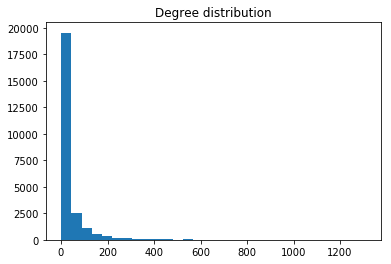

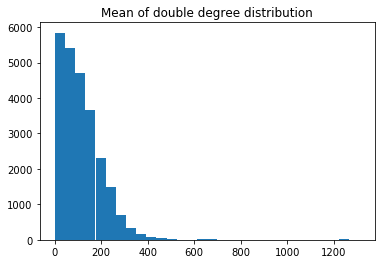

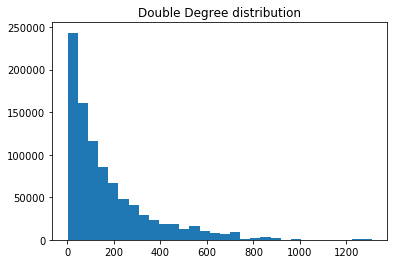

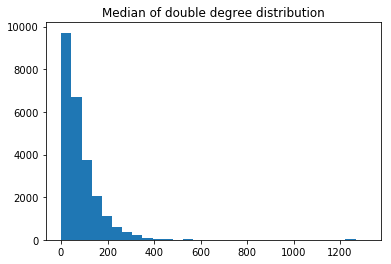

In [12]:
plot_dist(vk_g)

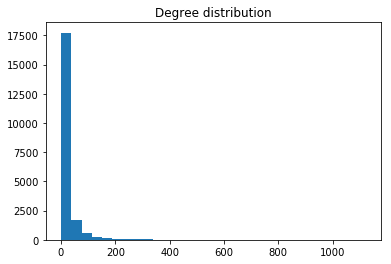

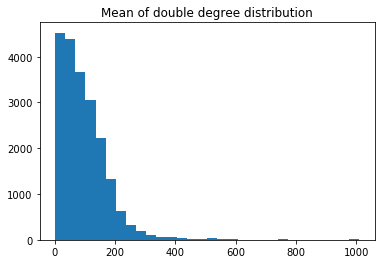

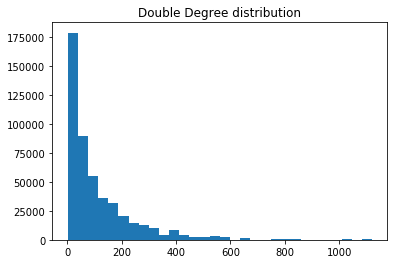

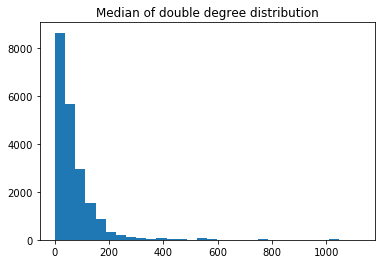

In [13]:
plot_dist(inst_g)

### Choose name similarity function

In [14]:
reload(utils)
df = utils.read_combine_df(from_raw = False)
df.head()

     uid_inst           uname          name_inst  uid_vk          name_vk
0   751026638       mrzelkin1     aleksej zelkin    5394    alexey zelkin
1     2744159         undruha  andrey gnelitskiy   22884  andre undrukhov
2  4157858483       vadimbhai     abhairov vadim   23754    vadim reutsky
3   389335890  superov_sergey     sergey superov   89831   sergey superov
4   199238507       smilychka       nastja gogol  103177     nastya gogol


,uid_inst,uname,name_inst,uid_vk,name_vk
0,751026638,mrzelkin1,aleksej zelkin,5394,alexey zelkin
1,2744159,undruha,andrey gnelitskiy,22884,andre undrukhov
2,4157858483,vadimbhai,abhairov vadim,23754,vadim reutsky
3,389335890,superov_sergey,sergey superov,89831,sergey superov
4,199238507,smilychka,nastja gogol,103177,nastya gogol


In [15]:
def soundex(name, len=4):
    """ soundex module conforming to Knuth's algorithm
        implementation 2000-12-24 by Gregory Jorgensen
        public domain
    """

    # digits holds the soundex values for the alphabet
    digits = '01230120022455012623010202'
    sndx = ''
    fc = ''

    # translate alpha chars in name to soundex digits
    for c in name.upper():
        if c.isalpha():
            if not fc: fc = c   # remember first letter
            d = digits[ord(c)-ord('A')]
            # duplicate consecutive soundex digits are skipped
            if not sndx or (d != sndx[-1]):
                sndx += d

    # replace first digit with first alpha character
    sndx = fc + sndx[1:]

    # remove all 0s from the soundex code
    sndx = sndx.replace('0','')

    # return soundex code padded to len characters
    return (sndx + (len * '0'))[:len]

def soundex_sim(a,b):
    a = soundex(a)
    b = soundex(b)
    return fuzz.token_sort_ratio(a,b) / 100

soundex('ildar nurgaliev')

'I436'

In [16]:
from fuzzywuzzy import fuzz
import Levenshtein as lev
from difflib import SequenceMatcher
from time import time

a = 'Ildar Nurgaliev'
b = 'Nurgaliev Ildar'

s = time()
print(fuzz.ratio(a,b) / 100)
e = time()
print('\tfuzz.ratio', e-s)

s = time()
print(fuzz.partial_ratio(a,b) / 100)
e = time()
print('\tpartial_ratio', e-s)

s = time()
print(fuzz.token_sort_ratio(a,b) / 100)
e = time()
print('\ttoken_sort_ratio', e-s)

s = time()
print(fuzz.token_set_ratio(a,b) / 100)
e = time()
print('\ttoken_set_ratio', e-s)

s = time()
print(lev.ratio(a,b))
e = time()
print('\tlev.ratio', e-s)

s = time()
seq = SequenceMatcher(None, a, b)
print(seq.ratio())
e = time()
print('\tSequenceMatcher', e-s)

s = time()
print(soundex_sim(a,b))
e = time()
print('\tsound', e-s)

0.6
	fuzz.ratio 0.0005631446838378906
0.6
	partial_ratio 0.0005767345428466797
1.0
	token_sort_ratio 0.0006344318389892578
1.0
	token_set_ratio 0.0005931854248046875
0.6
	lev.ratio 0.00035858154296875
0.6
	SequenceMatcher 0.0007536411285400391
0.25
	sound 0.0005011558532714844


In [17]:
df.head()

,uid_inst,uname,name_inst,uid_vk,name_vk
0,751026638,mrzelkin1,aleksej zelkin,5394,alexey zelkin
1,2744159,undruha,andrey gnelitskiy,22884,andre undrukhov
2,4157858483,vadimbhai,abhairov vadim,23754,vadim reutsky
3,389335890,superov_sergey,sergey superov,89831,sergey superov
4,199238507,smilychka,nastja gogol,103177,nastya gogol


In [18]:
def test_name_sim_fs():
    for row in df[['uname', 'name_inst', 'name_vk']].values[:150]:
        
        a,b = row[1:]
        s1 = lev.ratio(a,b)
        s2 = fuzz.token_sort_ratio(a,b) / 100
        s3 = fuzz.token_set_ratio(a,b) / 100
        c = s1 < s2
        if c:
            print('%s \t %s : %s' % (row[0], row[1], row[2]))
            print('!' if c else '','%.3f %.3f %.3f' % (s1, s2, s3))
        print()

test_name_sim_fs()



vadimbhai 	 abhairov vadim : vadim reutsky
! 0.370 0.520 0.560


smilychka 	 nastja gogol : nastya gogol
! 0.917 0.920 0.920





tatbeauty_ru 	 belorusskaja kosmetika : natalia sokolova
! 0.316 0.320 0.320

stasechka_ 	 garifullina anastasia : anastasia garifullina
! 0.524 1.000 1.000

iloshap 	 iloshap : ilona pekerman
! 0.476 0.480 0.480




more__life 	 valerya vorobeva : valeria vorobyeva
! 0.909 0.910 0.910










_alena_ko 	 alena pesoshina : alyona koroleva
! 0.467 0.470 0.470


retro_live_kzn 	 stanislav k : stanislav kotov
! 0.846 0.850 0.900

dj_xaker 	 djpate xakera : ildar khusainov
! 0.357 0.360 0.360








i.razetdinov 	 i r  ilgiz razetdinov : ilgiz razetdinov
! 0.865 0.890 1.000

nozdrina_t 	 tatjana nozdrina : tatyana nozdrina
! 0.938 0.940 0.940

alexandrievlev 	 aleksandr ievlev : alexander ievlev
! 0.875 0.880 0.880

a.petyhov 	 andrej petuhov : andrey petukhov
! 0.897 0.900 0.900


regina_aibyatova 	 regina : regina aybyatova
! 0.545 0.550 1.000


urmakuch 

### Distribution analysis

In [19]:
def run_permutation_test(pooled,sizeZ,sizeY,delta):
    np.random.shuffle(pooled)
    starZ = pooled[:sizeZ]
    starY = pooled[-sizeY:]
    return starZ.mean() - starY.mean()

def bootstrap_test(z,y):
    numSamples = 10000
    
    z = np.array(z)
    y = np.array(y)

    pooled = np.hstack([z,y])
    delta = z.mean() - y.mean()
    estimates = np.array(list(map(lambda x: run_permutation_test(pooled,z.size,y.size,delta),range(numSamples))))
    diffCount = len(np.where(estimates <= delta)[0])
    hat_asl_perm = 1.0 - (float(diffCount)/float(numSamples))
    return hat_asl_perm


bootstrap_test([94,197,16,38,99,141,23], [52,104,146,10,51,30,40,27,46])

0.13949999999999996

In [20]:
def feature(vl, bins=31, size=50):
    feature_set = [0 for i in range(2 * bins)]
    _1hop = [v.degree() for v in vl.neighbors()]
    for h in _1hop:
        if h < bins * size:
            feature_set[int(h / size)] += 1
#     _2hop = []
#     for vs in vl.neighbors():
#         _2hop += [v.degree() for v in vs.neighbors()]
#     for h in _2hop:
#         if h < bins * size:
#             feature_set[bins + int(h / size)] += 1
    return feature_set

a = feature(v)

NameError: name 'v' is not defined

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [ ]:
import itertools  as it
from scipy.stats import ks_2samp
from difflib import SequenceMatcher
import numpy as np
from random import random

def dist_sim(vr, vl):
    sl = [v.degree() for v in vl.neighbors()]
    sr = [v.degree() for v in vr.neighbors()]
    return ks_2samp(sl, sr)


def dist_sim2(vl, vr):
#     sl = []
#     for vs in vl.neighbors():
#         sl += [v.degree() for v in vs.neighbors()]
        
#     sr = []
#     for vs in vl.neighbors():
#         sr += [v.degree() for v in vs.neighbors()]
#     sl = [v.degree() for v in vl.neighbors()]
#     sr = [v.degree() for v in vr.neighbors()]
    bins=11
    size=50
    sl = feature(vl, bins, size)
    sr = feature(vr, bins, size)
    return bootstrap_test(sl, sr)

def neigbor_deg_dist(lg, rg):
    seq = SequenceMatcher()
#     for vl, vr in zip(it.islice(lg.vs, 40,50), it.islice(rg.vs, 10,30)):
    for vl in it.islice(lg.vs, 41, 42):
        vrt = rg.vs.find(name = vl['name'])
        
        for vr in [vrt] + vrt.neighbors():
            seq.set_seqs(vl['fname'], vr['fname'])
            t2 = dist_sim2(vl, vr)
            s = []
            for vn in vl.neighbors():
                s.append(vn.degree())
            f, axarr = plt.subplots(nrows = 1, ncols=2)
            axarr[0].hist(s, bins=30)
            axarr[0].set_title('%s %d\n %s %f\n %f' % (vl['name'], vl.degree(), vl['fname'], seq.ratio(), t2))
            for vn in vr.neighbors():
                s.append(vn.degree())
            axarr[1].hist(s, bins=30)

            plt.title('%s %d\n %s' % (vr['name'], vr.degree(), vr['fname']))
            plt.show()
            print(dist_sim(vl, vr))
    
neigbor_deg_dist(vk_g, inst_g)